In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
sys.path.insert(0,'/Users/weilu/Research/opt_server')
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [3]:
# data = pd.read_csv("/Users/weilu/Research/database/info_interaction_cutoff65_complete.csv", index_col=0)
data = pd.read_csv("/Users/weilu/Research/database/para_anti_para_with_six_letter_code.csv", index_col=0)
similar_size_protein_list = data["Protein"].value_counts().reset_index().query("Protein > 50 and Protein < 400")["index"].to_list()
# data_selected = data.query("Protein in @similar_size_protein_list").reset_index(drop=True)

In [4]:
len(similar_size_protein_list)

3252

In [5]:
pdb_list = similar_size_protein_list

In [6]:
pdb_list[0]

'6ybz'

In [7]:
res_set = {}
res_set['GLY'] = {'CA', 'N', 'O', 'C'}
res_set['ALA'] = {'CA', 'CB', 'N', 'O', 'C'}
res_set['VAL'] = {'CA', 'CB', 'CG2', 'CG1', 'N', 'O', 'C'}
res_set['CYS'] = {'CA', 'CB', 'SG', 'N', 'O', 'C'}
res_set['PRO'] = {'CA', 'CB', 'CG', 'CD', 'N', 'O', 'C'}
res_set['LEU'] = {'CD1', 'CA', 'CD2', 'CB', 'CG', 'N', 'O', 'C'}
res_set['ILE'] = {'CD1', 'CA', 'CB', 'CG2', 'CG1', 'N', 'O', 'C'}
res_set['MET'] = {'CA', 'CB', 'SD', 'CG', 'CE', 'N', 'O', 'C'}
res_set['TRP'] = {'CD1', 'CA', 'CZ3', 'NE1', 'CD2', 'CB', 'CG', 'CZ2', 'CH2', 'CE3', 'N', 'O', 'CE2', 'C'}
res_set['PHE'] = {'CD1', 'CA', 'CD2', 'CB', 'CE1', 'CG', 'CZ', 'N', 'O', 'CE2', 'C'}


res_set['SER'] = {'CA', 'OG', 'CB', 'N', 'O', 'C'}
res_set['THR'] = {'CA', 'CB', 'CG2', 'N', 'OG1', 'O', 'C'}
res_set['TYR'] = {'CD1', 'CA', 'CD2', 'CB', 'CE1', 'OH', 'CG', 'CZ', 'N', 'O', 'CE2', 'C'}
res_set["GLN"] = {'CA', 'CB', 'CG', 'CD', 'OE1', 'NE2', 'N', 'O', 'C'}
res_set['ASN'] = {'CA', 'OD1', 'CB', 'CG', 'ND2', 'N', 'O', 'C'}


res_set['LYS'] = {'CA', 'CB', 'CE', 'CG', 'CD', 'NZ', 'N', 'O', 'C'}
res_set['ARG'] = {'CA', 'NE', 'CB', 'CG', 'CD', 'NH2', 'CZ', 'NH1', 'N', 'O', 'C'}
res_set['HIS'] = {'CA', 'ND1', 'CD2', 'CB', 'CE1', 'CG', 'NE2', 'N', 'O', 'C'}


res_set['ASP'] = {'OD2', 'CA', 'OD1', 'CB', 'CG', 'N', 'O', 'C'}
res_set['GLU'] = {'CA', 'OE2', 'CB', 'CG', 'CD', 'OE1', 'N', 'O', 'C'}



def dis(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)**0.5

def get_neighbor_list_only_side_chain(structure):

    res_list = get_res_list(structure)
#     atom_list = [a for a in get_atom_list(
#         structure) if not is_hetero(a.get_parent())]
    atom_list = []
    for res in res_list:
        for atom in get_side_chain_atoms(res.get_atoms()):
            if is_hetero(atom.get_parent()):
                print("hetero, skipped")
                continue
            atom_list.append(atom)
    # print(atom_list)
    neighbor_list = NeighborSearch(atom_list)
    return neighbor_list

def get_side_chain_atoms(atoms):
    atom_list = []
    for atom in atoms:
        if atom.get_name() in ["N", "CA", "C", "O", "OXT"]:
            continue
        if atom.element == "H":
            continue
        atom_list.append(atom)
    return atom_list

def get_side_chain_center_of_mass(atoms):
    # ensure complete first
    total = np.array([0., 0., 0.])
    total_mass = 0
    for atom in atoms:
        if atom.get_name() in ["N", "CA", "C", "O", "OXT"]:
            continue
        if atom.element == "H":
            continue
        total += atom.mass * atom.get_coord()
        total_mass += atom.mass
        # print(atom.get_name(), atom.get_coord())
    x_com = total / total_mass
    return x_com


In [34]:
%%time

cutoff = 3.5
# cutoff = 4
# # res1.index should be at least 1 amino acid away
# They should be in direct contact. say 6.5.
parser = PDBParser()
info = []
skipped_residues_count = 0
# for i, a in enumerate(a_list[:300]):
# for i, a in enumerate(a_list[:10]):
for i, pdb in enumerate(pdb_list):
    if i % 100 == 0:
        print(i, pdb)
    fileLocation = f"/Users/weilu/Research/database/alpha_helical_membrane_protein_membrane_part_only/dompdb/{pdb}.pdb"
    structure = parser.get_structure("x", fileLocation)
    neighbor_list = get_neighbor_list_only_side_chain(structure)
    for res1 in structure.get_residues():
        resName1 = res1.get_resname()
        if resName1 == "GLY":
            continue
        set_of_all_non_H_atoms = get_all_non_H_atoms(res1)
        if set_of_all_non_H_atoms != res_set[resName1]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x_com_1 = get_side_chain_center_of_mass(res1.get_atoms())
        ca_1 = res1["CA"].get_coord()
        cb_1 = res1["CB"].get_coord()
        
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 10.0):
            resName2 = res2.get_resname()
            if resName2 == "GLY":
                continue
            set_of_all_non_H_atoms = get_all_non_H_atoms(res2)
            if set_of_all_non_H_atoms != res_set[resName2]:
                skipped_residues_count += 1
                # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
                continue
            if res1 == res2:
                continue
            in_real_contact = False
#             for atom in res1.get_atoms():
#                 if res2 in neighbor_list.search(atom.get_coord(), 4, level='R'):
#                     in_real_contact = True
            atom_list = get_side_chain_atoms(res1.get_atoms())
            for atom in atom_list:
                if res2 in neighbor_list.search(atom.get_coord(), cutoff, level='R'):
                    in_real_contact = True
            if not in_real_contact:
                # print(pdb, res1.id[1], resName1, res2.id[1], resName2)
                continue
            x_com_2 = get_side_chain_center_of_mass(res2.get_atoms())
            ca_2 = res2["CA"].get_coord()
            cb_2 = res2["CB"].get_coord()
            info.append([pdb, res1.id[1], resName1, res2.id[1], resName2, dis(ca_1, ca_2), dis(x_com_1, x_com_2), dis(cb_1, cb_2), dis(ca_1, x_com_2), dis(x_com_1, ca_2)])
print("skipped_residues_count", skipped_residues_count)

0 6ybz
100 1w5c
200 5ule
300 6t9o
400 6gyo
500 3abw
600 1pp9
700 6qph
800 6tyi
900 6oo5
1000 6fo2
1100 2qjk
1200 5klg
1300 4n4y
1400 4tpj
1500 6fl9
1600 6bpl
1700 4bew
1800 5aw5
1900 6rv3
2000 3spj
2100 4hul
2200 5oon
2300 4lcu
2400 3ze4
2500 5ebw
2600 6nq8
2700 6dg7
2800 3j7q
2900 6tq4
3000 5nx2
3100 6kk1
3200 3aef
skipped_residues_count 33792
CPU times: user 1h 11min 28s, sys: 19.5 s, total: 1h 11min 47s
Wall time: 1h 12min 29s


In [35]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape
data.to_csv("/Users/weilu/Research/data/survey_center_of_mass_distance_complete_side_chain_in_jul13.csv")

(775772, 10)

In [36]:
data.shape

(775772, 10)

In [38]:
data = pd.read_csv("/Users/weilu/Research/data/survey_center_of_mass_distance_complete_side_chain_in_jul13.csv", index_col=0)

In [96]:
data["i_sep"] = abs(data["id1"]-data["id2"])
d = data.query("i_sep >= 2 and r_com_com < r_ca_ca")

In [75]:
df_ = []

res_list = ['ARG', 'ASP', 'PRO', 'TRP', 'THR', 'HIS', 'GLU', 'LEU', 'SER',
       'LYS', 'VAL', 'PHE', 'ILE', 'TYR', 'GLN', 'ALA', 'ASN', 'MET',
       'CYS']


for res1 in res_list:
    data_res = d.query(f"ResName1 == '{res1}'")
    for res2 in res_list:
        data_one = data_res.query(f"ResName2 == '{res2}'").reset_index(drop=True)
        hist,bins = np.histogram(data_one["r_com_com"], bins=10)
        max_index = list(hist).index(max(hist))
        max_value = (bins[max_index + 1] + bins[max_index]) / 2
        lowest_value = bins[0]
        min_value = data_one["r_com_com"].min()
        max_hist = max(hist)
        #print(lowest_value)
        #print(max_value)
        df_temp = pd.DataFrame([(res1,res2,max_value, min_value, max_hist)], columns=["ResName1","ResName2","Max", "Min", "max_hist"])
        #print(df_temp)
        df_.append(df_temp)

#         fig, ax = plt.subplots()
#         _ = data_one.hist("r_com_com", bins=5, ax=ax, alpha=0.5)
#         plt.vlines(min_value-0.5, 0, hist[max_index], color="black")
#         plt.vlines(max_value, 0, hist[max_index], color="red")
#         plt.vlines(max_value+1.5, 0, hist[max_index], color="black")
#         plt.xlim([2,10])
#         plt.title(f"{res1}_{res2}")
#         plt.savefig(f"/Users/weilu/Research/database/survey_center_of_mass_distance/{res1}_{res2}_cutoff35.png", dpi=200)
#         _ = plt.clf()

#     break
# print(df)
df = pd.concat(df_)
# df.to_csv('/Users/weilu/Research/server/mar_2020/cmd_cmd_exclude_volume/cbd_cbd_real_contact_max_min_bins10_id_sep5.csv', index=False)

In [77]:
df["diff"] = df["Max"] -df["Min"]
df.columns = ['ResName1', 'ResName2', 'r_max', 'r_min', 'max_hist', 'diff']
df.to_csv('/Users/weilu/Research/data/cbd_cbd_real_contact_symmetric_jul13.csv', index=False)

In [80]:
df = pd.read_csv('/Users/weilu/Research/data/cbd_cbd_real_contact_symmetric_jul13.csv')

In [82]:
r = np.linspace(2, 8, 100)
r_p = 4.96
r_min = 2.44
y = np.heaviside(r_p-r, 0) * ((r_p-r)/(r_p-r_min))**2

Text(0.5, 1.0, 'r_p=4.96, r_min=2.44')

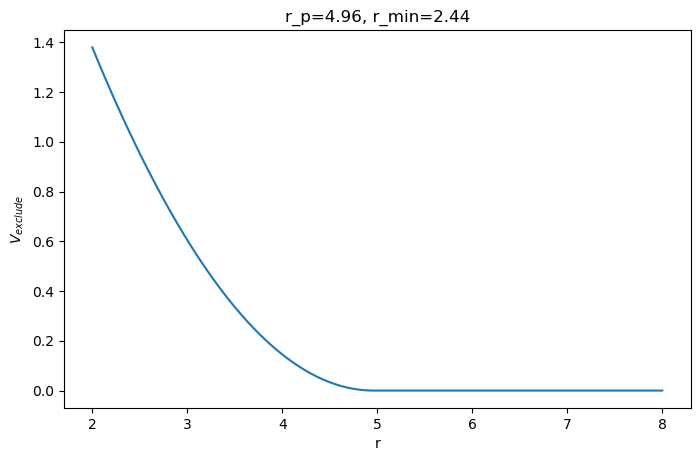

In [83]:
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.plot(r, y)
plt.xlabel("r")
plt.ylabel("$V_{exclude}$")
plt.title("r_p=4.96, r_min=2.44")

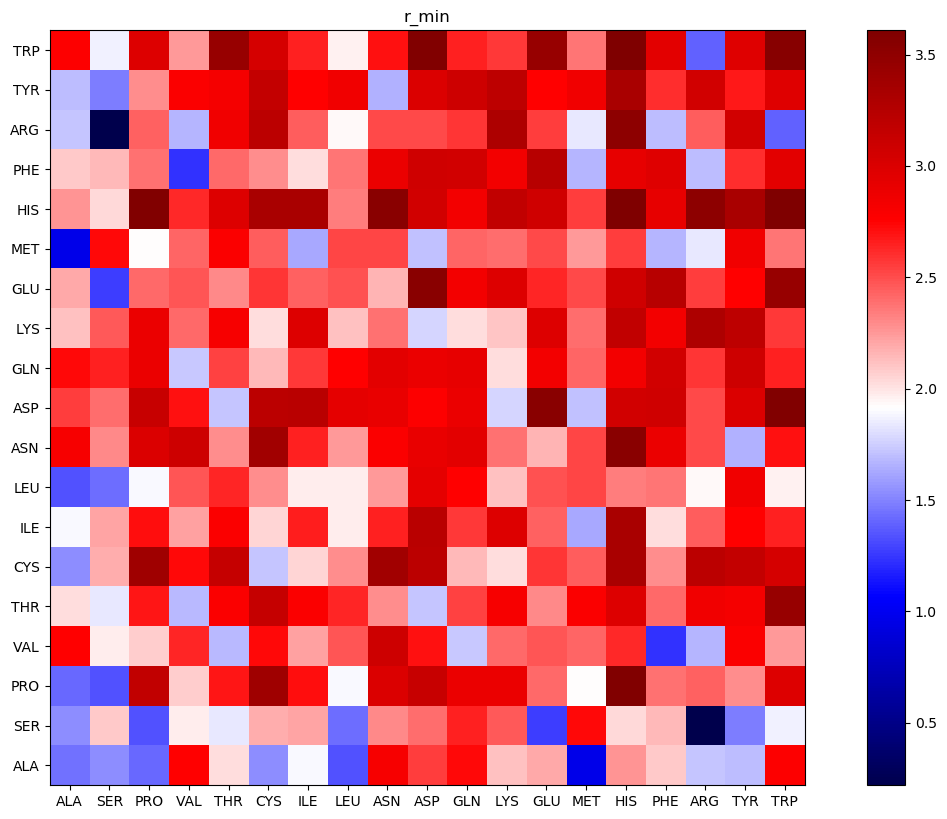

In [85]:
plt.rcParams['figure.figsize'] = 1*np.array([16.18033, 10])    #golden ratio
weight_list = ["ALA", "SER", "PRO", "VAL", "THR", "CYS", "ILE", "LEU", "ASN", "ASP", "GLN", "LYS", "GLU", "MET", "HIS", "PHE", "ARG", "TYR", "TRP"]
res_to_index = {}
for i, res in enumerate(weight_list):
    res_to_index[res] = i

min_r_com_com_matrix = np.zeros((19, 19))
for i, line in df.iterrows():
    res1 = line["ResName1"]
    res2 = line["ResName2"]
    min_r_com_com_matrix[res_to_index[res1]][res_to_index[res2]] = line["r_min"]
    
plt.imshow(min_r_com_com_matrix, origin=0, cmap="seismic")
plt.colorbar()
plt.title("r_min")
_ = plt.xticks(ticks=np.arange(19), labels=weight_list)
_ = plt.yticks(ticks=np.arange(19), labels=weight_list)

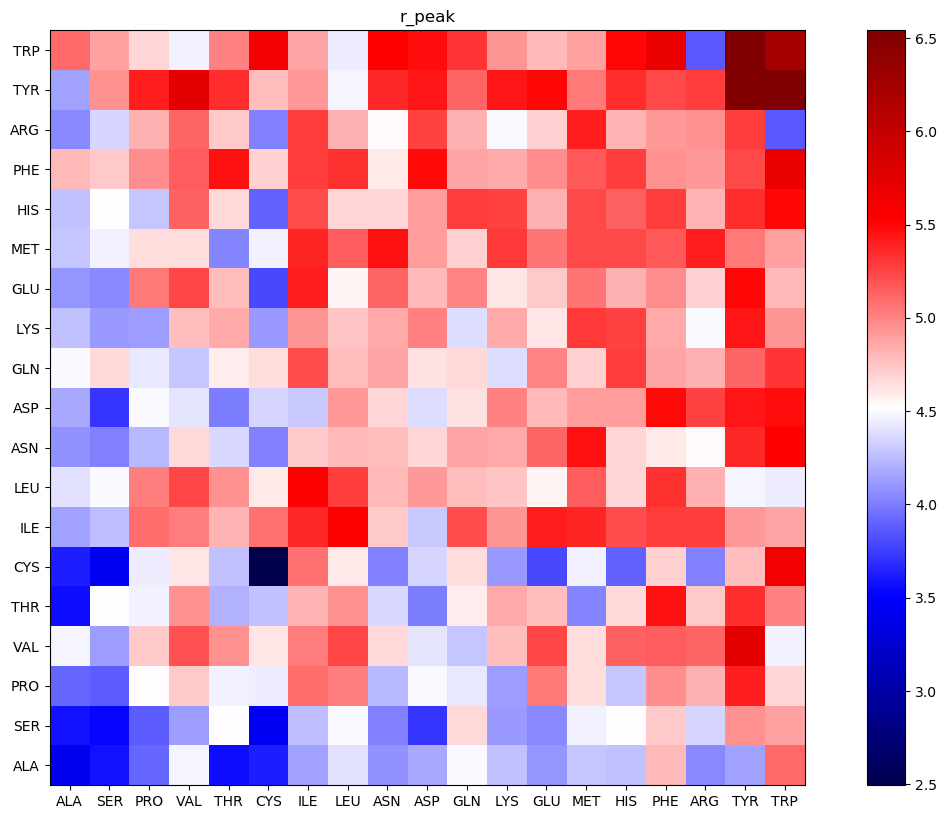

In [86]:
weight_list = ["ALA", "SER", "PRO", "VAL", "THR", "CYS", "ILE", "LEU", "ASN", "ASP", "GLN", "LYS", "GLU", "MET", "HIS", "PHE", "ARG", "TYR", "TRP"]
res_to_index = {}
for i, res in enumerate(weight_list):
    res_to_index[res] = i

min_r_com_com_matrix = np.zeros((19, 19))
for i, line in df.iterrows():
    res1 = line["ResName1"]
    res2 = line["ResName2"]
    min_r_com_com_matrix[res_to_index[res1]][res_to_index[res2]] = line["r_max"]
    
plt.imshow(min_r_com_com_matrix, origin=0, cmap="seismic")
plt.colorbar()
plt.title("r_peak")
_ = plt.xticks(ticks=np.arange(19), labels=weight_list)
_ = plt.yticks(ticks=np.arange(19), labels=weight_list)

In [106]:
data.query("r_com_com < 6 and r_cb_cb > 10")

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_cb_cb,r_ca_com,r_com_ca,i_sep
98,6ybz,160,GLU,243,ARG,13.099443,5.609117,10.282646,8.717363,10.156947,83
130,6ybz,243,ARG,160,GLU,13.099443,5.609117,10.282646,10.156947,8.717363,83
249,6ybz,160,GLU,243,ARG,13.101188,5.626215,10.283893,8.716912,10.181961,83
282,6ybz,243,ARG,160,GLU,13.101188,5.626215,10.283893,10.181961,8.716912,83
396,6ybz,160,GLU,243,ARG,13.137437,5.627816,10.314016,8.744986,10.188031,83
...,...,...,...,...,...,...,...,...,...,...,...
774578,6nbh,4,GLU,195,TYR,12.824212,5.918998,10.441244,9.158655,9.730577,191
775070,3hap,7,ARG,79,TYR,12.501962,5.824732,11.354363,8.763768,9.497310,72
775105,3hap,79,TYR,7,ARG,12.501962,5.824732,11.354363,9.497310,8.763768,72
775602,4py0,109,TYR,253,HIS,11.545374,5.770958,10.417029,8.501353,8.482704,144


In [47]:
data.groupby(["ResName1", "ResName2"])["Protein"].count().reset_index().sort_values("Protein")

,ResName1,ResName2,Protein
194,LYS,CYS,79
86,CYS,LYS,79
251,PRO,CYS,112
89,CYS,PRO,112
23,ARG,CYS,149
...,...,...,...
335,TYR,PHE,7554
180,LEU,LEU,8856
237,PHE,LEU,9558
183,LEU,PHE,9558


In [94]:
d.shape

(483554, 11)

Text(0.5, 1.0, 'TRP_ARG')

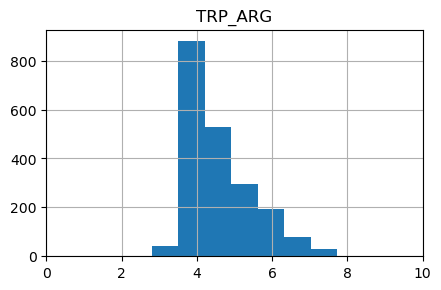

In [98]:
plt.rcParams['figure.figsize'] = 0.3*np.array([16.18033, 10])    #golden ratio
# VAL ALA
res1 = "TRP"
res2 = "ARG"
data_sel = d.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=10)
plt.xlim([0,10])
plt.title(f"{res1}_{res2}")

Text(0.5, 1.0, 'ARG_ARG')

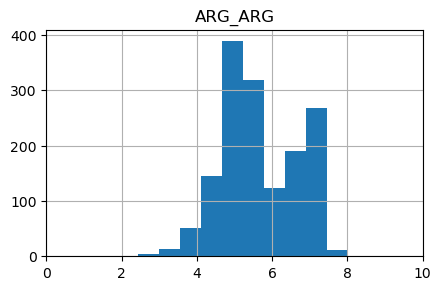

In [99]:
plt.rcParams['figure.figsize'] = 0.3*np.array([16.18033, 10])    #golden ratio
# VAL ALA
res1 = "ARG"
res2 = "ARG"
data_sel = d.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=10)
plt.xlim([0,10])
plt.title(f"{res1}_{res2}")

Text(0.5, 1.0, 'TRP_LYS')

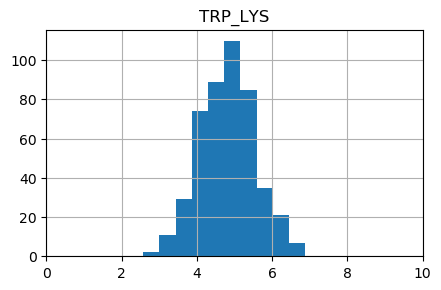

In [100]:
# VAL ALA
res1 = "TRP"
res2 = "LYS"
data_sel = d.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=10)
plt.xlim([0,10])
plt.title(f"{res1}_{res2}")

Text(0.5, 1.0, 'TRP_PRO')

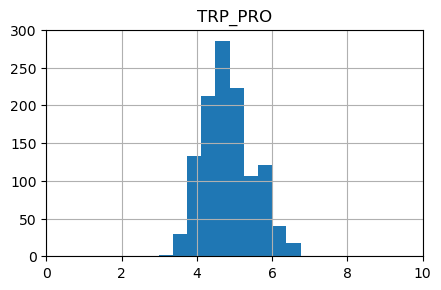

In [101]:
# VAL ALA
res1 = "TRP"
res2 = "PRO"
data_sel = d.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=10)
plt.xlim([0,10])
plt.title(f"{res1}_{res2}")

(0, 10)

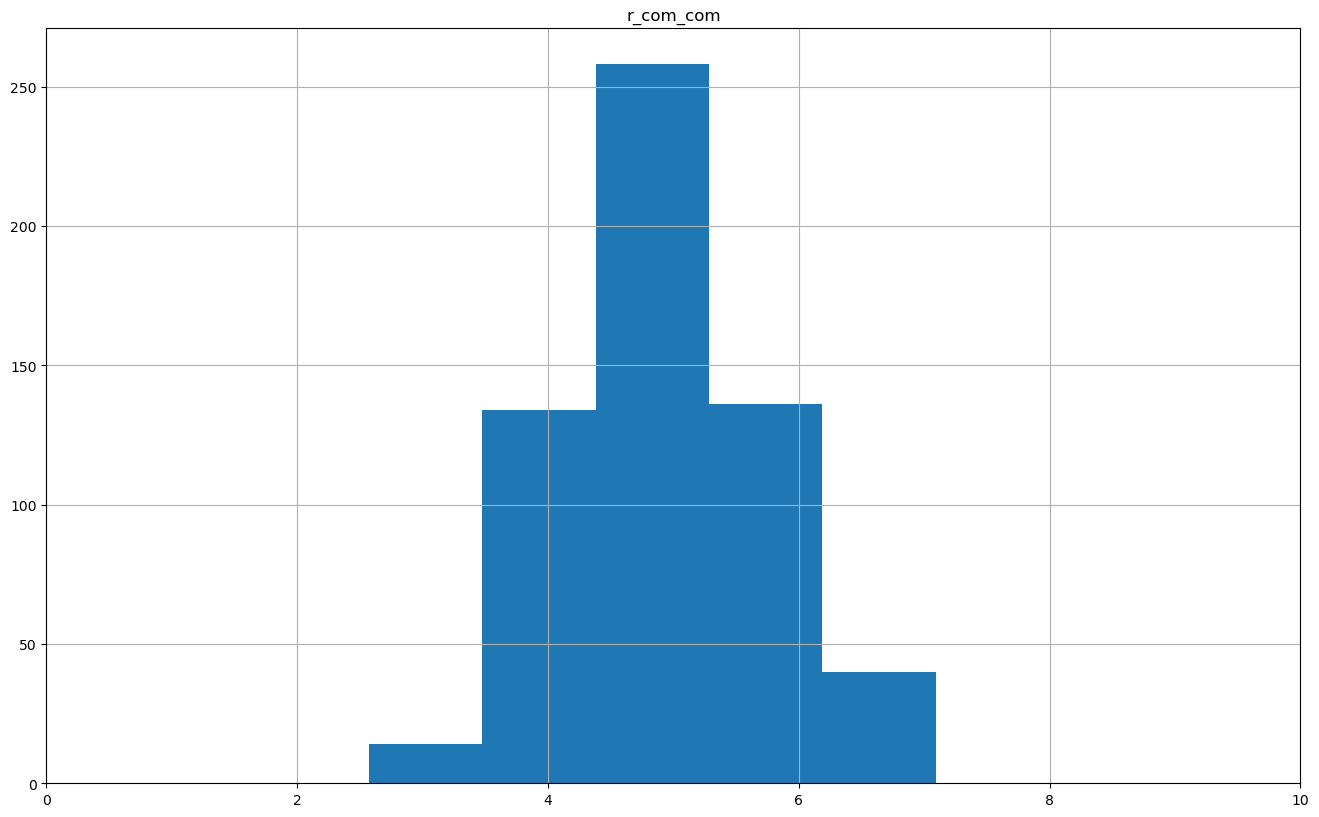

In [64]:
# VAL ALA
res1 = "TRP"
res2 = "LYS"
data_sel = data.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=5)
plt.xlim([0,10])

(0, 10)

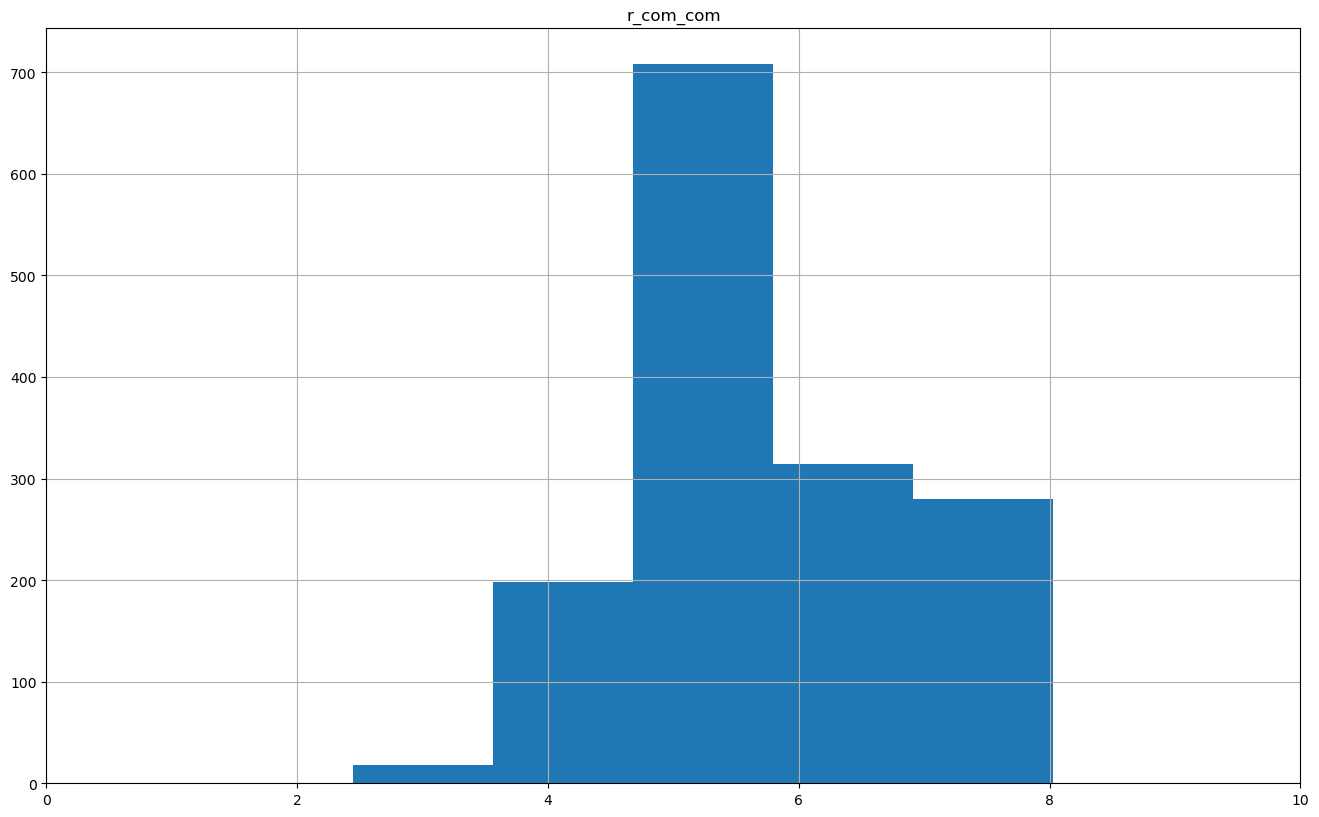

In [68]:
# VAL ALA
res1 = "ARG"
res2 = "ARG"
data_sel = d.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=5)
plt.xlim([0,10])

(0, 10)

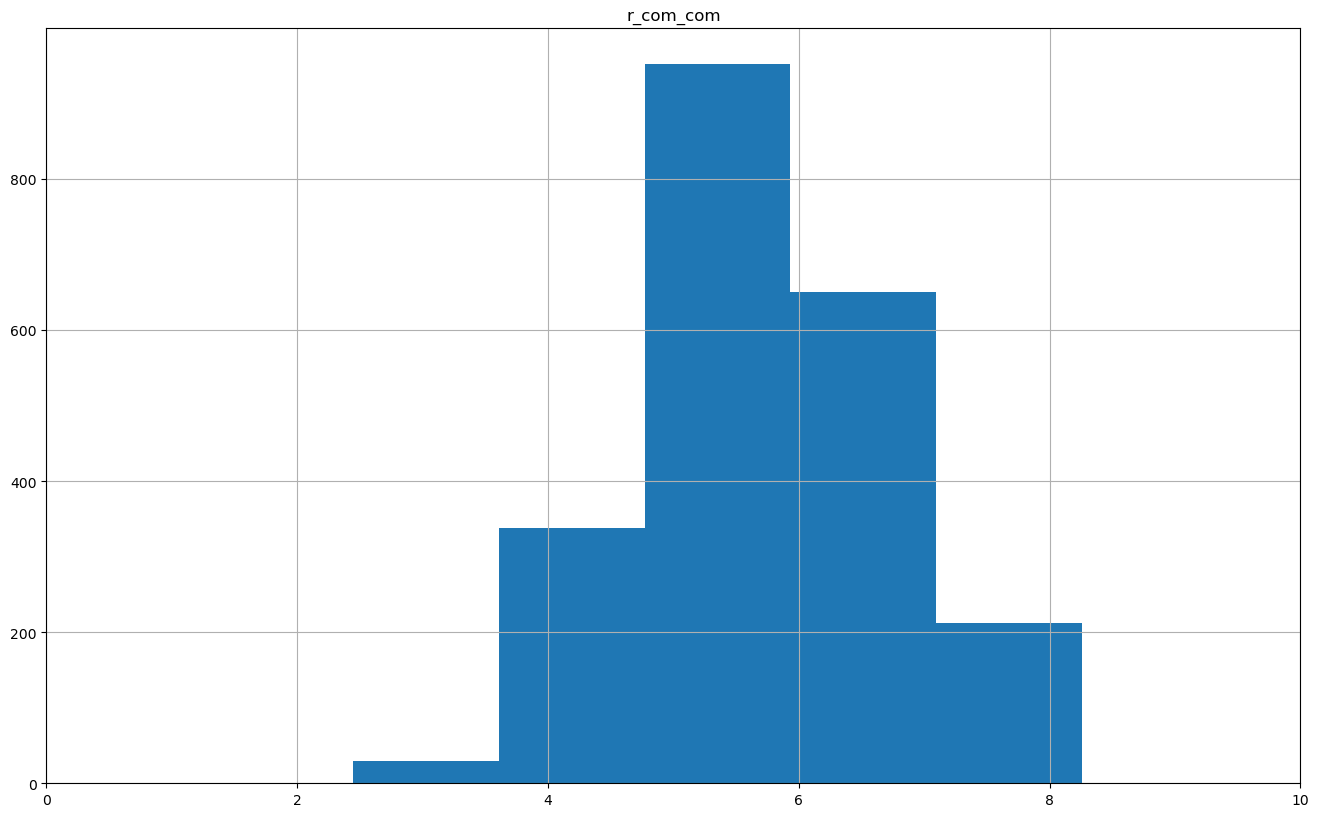

In [63]:
# VAL ALA
res1 = "ARG"
res2 = "ARG"
data_sel = data.query(f"ResName1 == '{res1}' and ResName2 == '{res2}'")
data_sel.hist("r_com_com", bins=5)
plt.xlim([0,10])

In [17]:
data["id"] = data["Protein"] + "_" + data["id1"].astype(str) + "_" + data["id2"].astype(str)

In [18]:
data_save["id"] = data_save["Protein"] + "_" + data_save["id1"].astype(str) + "_" + data_save["id2"].astype(str)

In [20]:
saved = data_save["id"].to_list()

In [26]:
data.shape

(19632, 11)

In [29]:
data.query("id not in @saved").sort_values("r_com_com")

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_cb_cb,r_ca_com,r_com_ca,id
2868,5h2f,250,PHE,459,ALA,5.730774,3.472973,4.479309,4.230477,4.642283,5h2f_250_459
2889,5h2f,459,ALA,250,PHE,5.730774,3.472973,4.479309,4.642283,4.230477,5h2f_459_250
11962,6ji1,332,TRP,396,ALA,5.947640,3.483375,4.751849,6.130568,4.014141,6ji1_332_396
12028,6ji1,396,ALA,332,TRP,5.947640,3.483375,4.751849,4.014141,6.130568,6ji1_396_332
12489,6ji1,396,ALA,332,TRP,5.947335,3.483622,4.751772,4.014113,6.130087,6ji1_396_332
...,...,...,...,...,...,...,...,...,...,...,...
16226,4m8j,327,TYR,150,TYR,9.150726,8.558712,8.541905,5.817747,12.328581,4m8j_327_150
5607,5h2f,18,TYR,23,PHE,10.303100,8.575750,9.201699,12.402741,6.438036,5h2f_18_23
5686,5h2f,23,PHE,18,TYR,10.303100,8.575750,9.201699,6.438036,12.402741,5h2f_23_18
3929,5h2f,23,PHE,18,TYR,10.408270,8.718864,9.319327,6.499718,12.629546,5h2f_23_18


In [25]:
len(saved)

5246

In [28]:
data_save.query("id1==10")

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_cb_cb,r_ca_com,r_com_ca,id
5,6ybz,10,PHE,240,VAL,8.100374,5.403468,7.627769,7.363209,5.457293,6ybz_10_240
152,6ybz,10,PHE,240,VAL,8.116997,5.416757,7.642736,7.383131,5.471006,6ybz_10_240
303,6ybz,10,PHE,240,VAL,8.121869,5.414193,7.646518,7.384462,5.470860,6ybz_10_240
448,6ybz,10,PHE,240,VAL,8.119193,5.420168,7.648534,7.386385,5.471973,6ybz_10_240
594,6ybz,10,PHE,243,ARG,10.820524,5.431835,8.712980,7.237382,8.126873,6ybz_10_243
595,6ybz,10,PHE,240,VAL,8.100433,5.397996,7.622450,7.357284,5.458359,6ybz_10_240
1100,5h2f,10,PHE,44,ILE,8.478214,5.303432,7.498997,8.537785,5.544527,5h2f_10_44
1101,5h2f,10,PHE,47,GLU,8.793755,5.385511,6.417544,6.120106,7.634366,5h2f_10_47
1451,5h2f,10,VAL,8,VAL,6.436435,4.984193,5.666716,5.903811,6.070769,5h2f_10_8


In [12]:
# data_save = data

In [110]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

In [108]:
pdb_filename = "/Users/weilu/Research/server/jul_week1_2020/protein_DNA/1nfk_with_long_DNA.pdb"
fixer = PDBFixer(filename=pdb_filename)

In [111]:
cleaned_pdb_filename = "/Users/weilu/Research/server/jul_week1_2020/protein_DNA/test.pdb"
PDBFile.writeFile(fixer.topology, fixer.positions, open(cleaned_pdb_filename, 'w'), keepIds=False)

In [112]:
pdb_filename = "/Users/weilu/Research/server/jul_week1_2020/protein_DNA/test.pdb"
a = PDBFile(pdb_filename)

In [113]:
a.topology

<Topology; 4 chains, 1046 residues, 4916 atoms, 0 bonds>

I assume that the first DNA chain is chain A, and second DNA chain is chain B


In [125]:
start_of_second_chain

105

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,0,T,,DT,C,1,,-3.440,11.838,41.523,0.0,0.0,S,,T
1,ATOM,2,G,,DG,C,2,,-3.968,12.426,35.272,0.0,0.0,C,,G
2,ATOM,5,G,,DG,C,3,,-4.020,15.462,32.554,0.0,0.0,C,,G
3,ATOM,8,G,,DG,C,4,,-3.148,15.739,29.055,0.0,0.0,C,,G
4,ATOM,11,A,,DA,C,5,,-2.053,16.146,25.587,0.0,0.0,N,,A
5,ATOM,14,A,,DA,C,6,,-0.002,15.268,22.405,0.0,0.0,N,,A
6,ATOM,17,T,,DT,C,7,,1.143,14.886,18.927,0.0,0.0,S,,T
7,ATOM,20,T,,DT,C,8,,1.005,13.390,15.362,0.0,0.0,S,,T
8,ATOM,23,C,,DC,C,9,,-1.374,12.691,11.852,0.0,0.0,O,,C
9,ATOM,26,C,,DC,C,10,,-3.631,13.387,8.247,0.0,0.0,O,,C


In [126]:
new_dna_dna_only.query("resname in @DNA_resNames").query("name in @interacting_atom")

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,0,ATOM,1,A,,DA,A,1,,-0.440,2.425,0.012,1.0,0.0,N,,A
2,2,ATOM,3,A,,DA,A,2,,-1.740,1.565,3.231,1.0,0.0,N,,A
5,5,ATOM,6,A,,DA,A,3,,-2.295,0.225,6.500,1.0,0.0,N,,A
8,8,ATOM,9,A,,DA,A,4,,-1.963,-1.076,9.814,1.0,0.0,N,,A
11,11,ATOM,12,A,,DA,A,5,,-0.931,-1.830,13.154,1.0,0.0,N,,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,1249,ATOM,1251,T,,DT,B,207,,2.378,2.957,13.084,1.0,0.0,S,,T
1252,1252,ATOM,1254,T,,DT,B,208,,3.503,0.918,9.919,1.0,0.0,S,,T
1255,1255,ATOM,1257,T,,DT,B,209,,3.315,-1.312,6.689,1.0,0.0,S,,T
1258,1258,ATOM,1260,T,,DT,B,210,,1.945,-2.935,3.384,1.0,0.0,S,,T


In [122]:
resSeq

213

In [181]:
pre = "/Users/weilu/Research/server/jul_week1_2020/protein_DNA/"
pdb = "1nfk"
setupFolder = "setups"
original_pdb_file = f"{pre}/{setupFolder}/with_formated_DNA_{pdb}_clean.pdb"
new_dna_pdb_file = f"{pre}/{pdb}_with_long_DNA.pdb"
bond_info_file = f"{pre}/bond_info_{pdb}_with_long_DNA.csv"
        
sys.path.append("/projects/pw8/wl45/open3spn2")
sys.path.append("/projects/pw8/wl45/openawsem")
sys.path.append("/Users/weilu/open3spn2")
sys.path.append("/Users/weilu/openmmawsem")
sys.path.append("C:/Users/luwei/Documents/GitHub/open3spn2")
sys.path.append("C:/Users/luwei/Documents/GitHub/openawsem")


import open3SPN2


DNA_resNames = ["DA", "DC", "DT", "DG"]
# pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/6cta_with_long_DNA.pdb"
pdb_file = new_dna_pdb_file
dna=open3SPN2.DNA.fromCoarsePDB(pdb_file)
new_dna = dna.atoms.reset_index()
new_dna_dna_only = new_dna.query("resname in @DNA_resNames")
pdb_file = original_pdb_file
# pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/setups/with_formated_DNA_6cta_clean.pdb"
# seq_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.seq"
dna=open3SPN2.DNA.fromCoarsePDB(pdb_file)

# before, i didn't renumber the residue to start from 1 for every chain.
# start_of_second_chain =  int((new_dna_dna_only["resSeq"].max())/2)
start_of_second_chain = -1
print("I assume that the first DNA chain is chain A, and second DNA chain is chain B")
bond_length_cutoff=1.8
data = dna.atoms
bonds_list = []

interacting_atom = ["A", "C", "G", "T"]
a = data.query("resname in @DNA_resNames").query("name in @interacting_atom").reset_index(drop=True)
n_atom = len(a)
for i in range(n_atom):
    dna_res_1 = a.iloc[i]
    chainID_1 = dna_res_1["chainID"]
    for j in range(i+1, n_atom):
        dna_res_2 = a.iloc[j]
        chainID_2 = dna_res_2["chainID"]
        if chainID_1 == chainID_2:
            continue

        atom1_pos = dna_res_1[["x", "y", "z"]].values
        atom2_pos = dna_res_2[["x", "y", "z"]].values
        dis = atom1_pos - atom2_pos
        r = (dis[0]**2 + dis[1]**2 + dis[2]**2)**0.5
        r /= 10   # convert to nm
        if r > bond_length_cutoff:
            # bong length larger than r will be ignored.
            continue
        # print(i, j, r)
        name = dna_res_1["name"]
        resSeq = dna_res_1["resSeq"] + 100
        target_atom = new_dna_dna_only.query(f"resSeq=={resSeq} and name=='{name}' and chainID=='A'")
        if len(target_atom) != 1:
            print(target_atom)
        else:
            serial_1 = int(target_atom["index"])

        name = dna_res_2["name"]
        resSeq = dna_res_2["resSeq"] + start_of_second_chain + 100
        target_atom = new_dna_dna_only.query(f"resSeq=={resSeq} and name=='{name}' and chainID=='B'")
        if len(target_atom) != 1:
            # print(dna_res_1, dna_res_2, chainID_1, chainID_2, target_atom)
            print(dna_res_1["name"], dna_res_1["resSeq"] + 100, name, resSeq)
            pass
        else:
            serial_2 = int(target_atom["index"])
#         bonds_list.append([dna_res_1["serial"], dna_res_2["serial"], r])
        bonds_list.append([serial_1, serial_2, r, dna_res_1["name"], dna_res_2["name"], dna_res_1["resSeq"], dna_res_2["resSeq"]])
        # print(dna_res_1["name"], dna_res_2["name"], dna_res_1["resSeq"], dna_res_2["resSeq"], serial_1, serial_2, r)

bond_info = pd.DataFrame(bonds_list, columns=["atom1", "atom2", "r", "res1_name", "res2_name", "res1", "res2"])
# bond_info.to_csv(bond_info_file)

I assume that the first DNA chain is chain A, and second DNA chain is chain B


In [210]:
pre = "/Users/weilu/Research/server/jul_week1_2020/protein_DNA/"
pdb = "1nfk"
setupFolder = "setups"
original_pdb_file = f"{pre}/{setupFolder}/with_formated_DNA_{pdb}_clean.pdb"
new_dna_pdb_file = f"{pre}/{pdb}_with_long_DNA.pdb"
bond_info_file = f"{pre}/bond_info_{pdb}_with_long_DNA.csv"
        
sys.path.append("/projects/pw8/wl45/open3spn2")
sys.path.append("/projects/pw8/wl45/openawsem")
sys.path.append("/Users/weilu/open3spn2")
sys.path.append("/Users/weilu/openmmawsem")
sys.path.append("C:/Users/luwei/Documents/GitHub/open3spn2")
sys.path.append("C:/Users/luwei/Documents/GitHub/openawsem")


import open3SPN2


DNA_resNames = ["DA", "DC", "DT", "DG"]
# pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/6cta_with_long_DNA.pdb"
pdb_file = new_dna_pdb_file
dna=open3SPN2.DNA.fromCoarsePDB(pdb_file)
new_dna = dna.atoms.reset_index()
new_dna_dna_only = new_dna.query("resname in @DNA_resNames")
pdb_file = original_pdb_file
# pdb_file = "/Users/weilu/Research/server/jun_week3_2020/automatic_man_made_DNA/setups/with_formated_DNA_6cta_clean.pdb"
# seq_file = "/Users/weilu/Research/server/jun_week3_2020/man_made_DNA/1mnn_with_long_DNA.seq"
dna=open3SPN2.DNA.fromCoarsePDB(pdb_file)


protein_resNames = ["NGP", "IGL", "IPR", "NTER", "CTER"]
ca_protein = data.query("resname in @protein_resNames").query("name == 'CA'").reset_index(drop=True)
new_ca_protein = new_dna.query("resname in @protein_resNames").query("name == 'CA'").reset_index(drop=True)
n_protein_res = len(ca_protein)
assert n_protein_res == len(new_ca_protein)


# before, i didn't renumber the residue to start from 1 for every chain.
# start_of_second_chain =  int((new_dna_dna_only["resSeq"].max())/2)
start_of_second_chain = -1
print("I assume that the original and new pdb chain ID is the same.")
bond_length_cutoff=1.8
data = dna.atoms
bonds_list = []

interacting_atom = ["A", "C", "G", "T"]
a = data.query("resname in @DNA_resNames").query("name in @interacting_atom").reset_index(drop=True)
n_atom = len(a)


for i in range(n_atom):
    dna_res_1 = a.iloc[i]
    chainID_1 = dna_res_1["chainID"]
    for j in range(n_protein_res):
        ca_res_2 = ca_protein.iloc[j]
        chainID_2 = ca_res_2["chainID"]

        atom1_pos = dna_res_1[["x", "y", "z"]].values
        atom2_pos = ca_res_2[["x", "y", "z"]].values
        dis = atom1_pos - atom2_pos
        r = (dis[0]**2 + dis[1]**2 + dis[2]**2)**0.5
        r /= 10   # convert to nm
        if r > bond_length_cutoff:
            # bong length larger than r will be ignored.
            continue
        # print(i, j, r)
        name = dna_res_1["name"]
        if chainID_1 == "A":
            shift = 100
        elif chainID_1 == "B":
            shift = 99
        resSeq = dna_res_1["resSeq"] + shift
        target_atom = new_dna_dna_only.query(f"resSeq=={resSeq} and name=='{name}' and chainID=='{chainID_1}'")
        if len(target_atom) != 1:
            # print(target_atom)
            print(dna_res_1["name"], dna_res_1["resSeq"], name, resSeq)
        else:
            serial_1 = int(target_atom["index"])

        name = ca_res_2["name"]
        resSeq = ca_res_2["resSeq"]
        target_atom = new_ca_protein.query(f"resSeq=={resSeq} and name=='{name}' and chainID=='{chainID_2}'")
        if len(target_atom) != 1:
            # print(dna_res_1, dna_res_2, chainID_1, chainID_2, target_atom)
            print(dna_res_1["name"], dna_res_1["resSeq"], name, resSeq)
            pass
        else:
            serial_2 = int(target_atom["index"])
#         bonds_list.append([dna_res_1["serial"], dna_res_2["serial"], r])
        bonds_list.append([serial_1, serial_2, r, dna_res_1["name"], ca_res_2["name"], dna_res_1["resSeq"], ca_res_2["resSeq"], chainID_1, chainID_2])
        # print(dna_res_1["name"], dna_res_2["name"], dna_res_1["resSeq"], dna_res_2["resSeq"], serial_1, serial_2, r)

bond_info = pd.DataFrame(bonds_list, columns=["DNA_atom_index", "Protein_atom_index", "r", "res1_name", "res2_name", "res1", "res2", "chain1", "chain2"])
# bond_info.to_csv(bond_info_file)

I assume that the original and new pdb chain ID is the same.


In [212]:
bond_info

,DNA_atom_index,Protein_atom_index,r,res1_name,res2_name,res1,res2,chain1,chain2
0,299,3165,1.724491,T,CA,1,14,A,D
1,299,3170,1.540959,T,CA,1,15,A,D
2,299,3176,1.376666,T,CA,1,16,A,D
3,299,3182,1.515649,T,CA,1,17,A,D
4,299,3188,1.315242,T,CA,1,18,A,D
...,...,...,...,...,...,...,...,...,...
1093,958,3682,1.594761,C,CA,11,103,B,D
1094,958,3688,1.788010,C,CA,11,104,B,D
1095,958,3694,1.798881,C,CA,11,105,B,D
1096,958,4267,1.711644,C,CA,11,202,B,D


In [190]:
bond_info

,DNA_atom_index,Protein_atom_index,r,res1_name,res2_name,res1,res2,chain1,chain2
0,299,3165,1.724491,T,CA,1,14,A,D
1,299,3170,1.540959,T,CA,1,15,A,D
2,299,3176,1.376666,T,CA,1,16,A,D
3,299,3182,1.515649,T,CA,1,17,A,D
4,299,3188,1.315242,T,CA,1,18,A,D
...,...,...,...,...,...,...,...,...,...
1093,958,3682,1.594761,C,CA,11,103,B,D
1094,958,3688,1.788010,C,CA,11,104,B,D
1095,958,3694,1.798881,C,CA,11,105,B,D
1096,958,4267,1.711644,C,CA,11,202,B,D


In [174]:
bond_info

,atom1,atom2,r,res1_name,res2_name,res1,res2
0,299,949,1.715767,T,T,1,8
1,299,952,1.386955,T,C,1,9
2,299,955,1.042629,T,C,1,10
3,299,958,0.752803,T,C,1,11
4,302,943,1.721075,G,A,2,6
...,...,...,...,...,...,...,...
81,329,934,0.589491,C,G,11,3
82,329,937,0.798772,C,G,11,4
83,329,940,1.081095,C,A,11,5
84,329,943,1.353934,C,A,11,6


In [150]:
bond_info

,atom1,atom2,r
0,299,946,1.715767
1,299,955,1.386955
2,299,958,1.042629
3,299,958,0.752803
4,302,958,1.721075
...,...,...,...
81,329,937,0.589491
82,329,937,0.798772
83,329,943,1.081095
84,329,943,1.353934


In [195]:
a1 = new_dna_dna_only.query(" name in @interacting_atom and chainID =='A'")["name"]

'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATGGGAATTCCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

In [198]:
from Bio.Seq import reverse_complement

In [199]:
aa = reverse_complement("".join(a1.to_list()))

In [200]:
aa

'TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGGGAATTCCCATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT'

In [201]:
b1 = "".join(new_dna_dna_only.query(" name in @interacting_atom and chainID =='B'")["name"].to_list())

In [203]:
aa == b1

True

In [205]:
b1[:101]

'TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTG'

In [202]:
b1

'TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGGGAATTCCCATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT'

In [191]:
a

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,0,T,,DT,A,1,,-3.440,11.838,41.523,0.0,0.0,S,,T
1,ATOM,2,G,,DG,A,2,,-3.968,12.426,35.272,0.0,0.0,C,,G
2,ATOM,5,G,,DG,A,3,,-4.020,15.462,32.554,0.0,0.0,C,,G
3,ATOM,8,G,,DG,A,4,,-3.148,15.739,29.055,0.0,0.0,C,,G
4,ATOM,11,A,,DA,A,5,,-2.053,16.146,25.587,0.0,0.0,N,,A
5,ATOM,14,A,,DA,A,6,,-0.002,15.268,22.405,0.0,0.0,N,,A
6,ATOM,17,T,,DT,A,7,,1.143,14.886,18.927,0.0,0.0,S,,T
7,ATOM,20,T,,DT,A,8,,1.005,13.390,15.362,0.0,0.0,S,,T
8,ATOM,23,C,,DC,A,9,,-1.374,12.691,11.852,0.0,0.0,O,,C
9,ATOM,26,C,,DC,A,10,,-3.631,13.387,8.247,0.0,0.0,O,,C


In [141]:
new_dna_dna_only.query("resSeq > 99 and resSeq < 112 and name in @interacting_atom and chainID =='A'")

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
296,296,ATOM,297,A,,DA,A,100,,-14.281,7.783,322.758,1.0,0.0,N,,A
299,299,ATOM,300,T,,DT,A,101,,-14.457,8.865,326.230,1.0,0.0,S,,T
302,302,ATOM,303,G,,DG,A,102,,-16.874,9.686,329.433,1.0,0.0,C,,G
305,305,ATOM,306,G,,DG,A,103,,-18.305,8.929,332.707,1.0,0.0,C,,G
308,308,ATOM,309,G,,DG,A,104,,-19.024,7.463,335.973,1.0,0.0,C,,G
311,311,ATOM,312,A,,DA,A,105,,-19.380,6.105,339.357,1.0,0.0,N,,A
314,314,ATOM,315,A,,DA,A,106,,-18.619,4.591,342.506,1.0,0.0,N,,A
317,317,ATOM,318,T,,DT,A,107,,-17.911,3.526,345.916,1.0,0.0,S,,T
320,320,ATOM,321,T,,DT,A,108,,-15.670,2.856,349.069,1.0,0.0,S,,T
323,323,ATOM,324,C,,DC,A,109,,-13.439,3.564,352.274,1.0,0.0,O,,C


In [192]:
new_dna_dna_only.query("resSeq > 99 and resSeq < 112 and name in @interacting_atom and chainID =='B'")

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
928,928,ATOM,928,T,,DT,B,100,,-18.639,4.583,361.809,1.0,0.0,S,,T
931,931,ATOM,931,G,,DG,B,101,,-18.258,7.369,358.761,1.0,0.0,C,,G
934,934,ATOM,934,G,,DG,B,102,,-17.001,8.494,355.506,1.0,0.0,C,,G
937,937,ATOM,937,G,,DG,B,103,,-15.492,8.633,352.169,1.0,0.0,C,,G
940,940,ATOM,940,A,,DA,B,104,,-14.281,8.506,348.711,1.0,0.0,N,,A
943,943,ATOM,943,A,,DA,B,105,,-13.513,7.318,345.418,1.0,0.0,N,,A
946,946,ATOM,946,T,,DT,B,106,,-13.133,6.447,341.937,1.0,0.0,S,,T
949,949,ATOM,949,T,,DT,B,107,,-13.852,4.430,338.642,1.0,0.0,S,,T
952,952,ATOM,952,C,,DC,B,108,,-15.762,3.117,335.403,1.0,0.0,O,,C
955,955,ATOM,955,C,,DC,B,109,,-17.966,3.494,332.259,1.0,0.0,O,,C


In [139]:
new_dna_dna_only.query("resSeq > 99 and resSeq < 112 and name in @interacting_atom and chainID =='B'")

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
928,928,ATOM,930,T,,DT,B,100,,-18.639,4.583,361.809,1.0,0.0,S,,T
931,931,ATOM,933,G,,DG,B,101,,-18.258,7.369,358.761,1.0,0.0,C,,G
934,934,ATOM,936,G,,DG,B,102,,-17.001,8.494,355.506,1.0,0.0,C,,G
937,937,ATOM,939,G,,DG,B,103,,-15.492,8.633,352.169,1.0,0.0,C,,G
940,940,ATOM,942,A,,DA,B,104,,-14.281,8.506,348.711,1.0,0.0,N,,A
943,943,ATOM,945,A,,DA,B,105,,-13.513,7.318,345.418,1.0,0.0,N,,A
946,946,ATOM,948,T,,DT,B,106,,-13.133,6.447,341.937,1.0,0.0,S,,T
949,949,ATOM,951,T,,DT,B,107,,-13.852,4.430,338.642,1.0,0.0,S,,T
952,952,ATOM,954,C,,DC,B,108,,-15.762,3.117,335.403,1.0,0.0,O,,C
955,955,ATOM,957,C,,DC,B,109,,-17.966,3.494,332.259,1.0,0.0,O,,C


In [140]:
new_dna_dna_only

,index,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,0,ATOM,1,A,,DA,A,1,,-0.440,2.425,0.012,1.0,0.0,N,,A
1,1,ATOM,2,S,,DA,A,1,,-2.790,6.611,-0.769,1.0,0.0,H,,S
2,2,ATOM,3,A,,DA,A,2,,-1.740,1.565,3.231,1.0,0.0,N,,A
3,3,ATOM,4,P,,DA,A,2,,-5.581,7.213,1.561,1.0,0.0,P,,P
4,4,ATOM,5,S,,DA,A,2,,-6.079,3.596,2.392,1.0,0.0,H,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,1259,ATOM,1261,P,,DT,B,210,,5.100,-7.850,5.366,1.0,0.0,P,,P
1260,1260,ATOM,1262,S,,DT,B,210,,1.513,-7.150,4.490,1.0,0.0,H,,S
1261,1261,ATOM,1263,T,,DT,B,211,,-0.036,-3.380,0.020,1.0,0.0,S,,T
1262,1262,ATOM,1264,P,,DT,B,211,,-0.345,-9.265,1.840,1.0,0.0,P,,P


In [151]:
dna

3SPN2 DNA object (3716 atoms)

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,0,T,,DT,C,1,,-3.440,11.838,41.523,0.0,0.0,S,,T
1,ATOM,1,S,,DT,C,1,,-7.043,10.519,39.692,0.0,0.0,H,,S
2,ATOM,2,G,,DG,C,2,,-3.968,12.426,35.272,0.0,0.0,C,,G
3,ATOM,3,P,,DG,C,2,,-9.991,12.205,38.307,0.0,0.0,P,,P
4,ATOM,4,S,,DG,C,2,,-7.717,14.887,36.906,0.0,0.0,H,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,ATOM,3711,N,,NGP,B,350,,-29.569,51.309,26.124,0.0,0.0,N,,N
3712,ATOM,3712,CA,,NGP,B,350,,-28.951,52.216,25.140,0.0,0.0,C,,CA
3713,ATOM,3713,O,,NGP,B,350,,-27.147,51.952,26.688,0.0,0.0,O,,O
3714,ATOM,3714,CB,,NGP,B,350,,-29.631,53.586,25.157,0.0,0.0,B,,CB


In [153]:
pdb_file = new_dna_pdb_file
dna=open3SPN2.DNA.fromCoarsePDB(pdb_file)
dna.atoms

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,1,A,,DA,A,1,,-0.440,2.425,0.012,1.0,0.0,N,,A
1,ATOM,2,S,,DA,A,1,,-2.790,6.611,-0.769,1.0,0.0,H,,S
2,ATOM,3,A,,DA,A,2,,-1.740,1.565,3.231,1.0,0.0,N,,A
3,ATOM,4,P,,DA,A,2,,-5.581,7.213,1.561,1.0,0.0,P,,P
4,ATOM,5,S,,DA,A,2,,-6.079,3.596,2.392,1.0,0.0,H,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4911,HETATM,4915,N,,NGP,D,312,,270.431,51.309,26.124,1.0,0.0,N,,N
4912,HETATM,4916,H,,NGP,D,312,,270.631,51.586,27.067,1.0,0.0,H,,H
4913,HETATM,4917,CA,,NGP,D,312,,271.049,52.216,25.140,1.0,0.0,C,,CA
4914,HETATM,4918,O,,NGP,D,312,,272.853,51.952,26.688,1.0,0.0,O,,O


In [154]:
dna.writePDB("/Users/weilu/Research/server/jul_week1_2020/protein_DNA/test.pdb")

KeyError: 'CA'

In [ ]:
def writePDB(atoms,pdb_file):
    with open(pdb_file, 'w+') as pdb:
        for i, atom in atoms.iterrows():
            pdb_line = f'{atom.recname:<6}{atom.serial:>5} {atom["name"]:^4}{atom.altLoc:1}'+\
                       f'{atom.resname:<3} {atom.chainID:1}{atom.resSeq:>4}{atom.iCode:1}   '+\
                       f'{atom.x:>8.3f}{atom.y:>8.3f}{atom.z:>8.3f}' +\
                       f'{atom.occupancy:>6.2f}{atom.tempFactor:>6.2f}'+' ' * 10 +\
                       f'{atom.element:>2}{atom.charge:>2}'
            assert len(pdb_line) == 80, f'An item in the atom table is longer than expected ({len(pdb_line)})\n{pdb_line}'
            pdb.write(pdb_line + '\n')
writePDB(dna.atoms,'/Users/weilu/Research/server/jul_week1_2020/protein_DNA/test.pdb')

In [168]:
def writePDB(atoms,pdb_file):
    with open(pdb_file, 'w+') as pdb:
        for i, atom in atoms.iterrows():
            pdb_line = f'{atom.recname:<6}{atom["index"]:>5} {atom["name"]:^4}{atom.altLoc:1}'+\
                       f'{atom.resname:<3} {atom.chainID:1}{atom.resSeq:>4}{atom.iCode:1}   '+\
                       f'{atom.x:>8.3f}{atom.y:>8.3f}{atom.z:>8.3f}' +\
                       f'{atom.occupancy:>6.2f}{atom.tempFactor:>6.2f}'+' ' * 10 +\
                       f'{atom.element:>2}{atom.charge:>2}'
            assert len(pdb_line) == 80, f'An item in the atom table is longer than expected ({len(pdb_line)})\n{pdb_line}'
            pdb.write(pdb_line + '\n')
writePDB(dna.atoms,'/Users/weilu/Research/server/jul_week1_2020/protein_DNA/test.pdb')

In [162]:
a = dna.atoms

In [165]:
a["index"] = a.index + 1

In [166]:
a

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type,index
0,ATOM,1,A,,DA,A,1,,-0.440,2.425,0.012,1.0,0.0,N,,A,1
1,ATOM,2,S,,DA,A,1,,-2.790,6.611,-0.769,1.0,0.0,H,,S,2
2,ATOM,3,A,,DA,A,2,,-1.740,1.565,3.231,1.0,0.0,N,,A,3
3,ATOM,4,P,,DA,A,2,,-5.581,7.213,1.561,1.0,0.0,P,,P,4
4,ATOM,5,S,,DA,A,2,,-6.079,3.596,2.392,1.0,0.0,H,,S,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4911,HETATM,4915,N,,NGP,D,312,,270.431,51.309,26.124,1.0,0.0,N,,N,4912
4912,HETATM,4916,H,,NGP,D,312,,270.631,51.586,27.067,1.0,0.0,H,,H,4913
4913,HETATM,4917,CA,,NGP,D,312,,271.049,52.216,25.140,1.0,0.0,C,,CA,4914
4914,HETATM,4918,O,,NGP,D,312,,272.853,51.952,26.688,1.0,0.0,O,,O,4915


In [159]:
dna.atoms.index

RangeIndex(start=0, stop=4916, step=1)